# Lecture 8

In [33]:
import neat
import random
import networkx as nx
import os
import pandas as pd
from math import log, sqrt, exp
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

Loading the synthetic data into pandas dataframes.

In [34]:
xls30_ = pd.ExcelFile("./synthetic_data/IOP_AOP_Sun30.xls")
xls60_ = pd.ExcelFile("./synthetic_data/IOP_AOP_Sun60.xls")

xls30 = {}
for sheet_name in xls30_.sheet_names:
    xls30[sheet_name] = xls30_.parse(sheet_name)
    xls30[sheet_name].drop(xls30[sheet_name].index[0:8], inplace=True)
    xls30[sheet_name].drop(xls30[sheet_name].columns[0], axis=1, inplace=True)
    xls30[sheet_name].reset_index(drop=True, inplace=True) 

xls60 = {}
for sheet_name in xls60_.sheet_names:
    xls60[sheet_name] = xls60_.parse(sheet_name)
    xls60[sheet_name].drop(xls60[sheet_name].index[0:8], inplace=True)
    xls60[sheet_name].drop(xls60[sheet_name].columns[0], axis=1, inplace=True)
    xls60[sheet_name].reset_index(drop=True, inplace=True) 

In [35]:
allbands = [f'{l}' for l in range(400,801,10)]
bands = ['411', '443', '489', '510', '560', '619', '665']
bands_n = [411, 443, 489, 510, 560, 619, 665]

In [36]:
input_params = ['Rrs', 'Kd(10)'] # Rrs at 8 wavelengths, Kd10 at single wavelength 443nm
output_params = ['a', 'bb'] # at single wavelength

In [37]:
for param in input_params + output_params:
    xls30[param].columns = allbands
    xls60[param].columns = allbands

Preparing training data. Parameters at 443nm wavelength need to be calculated via interpolation.

In [38]:
x = np.linspace(400, 800, num=41) # available bands in synthetic data set
x_ = np.linspace(400, 800, num=401) # for interpolation at 1nm steps

inputs = []
for i in range(500): # 500 data points at 30 deg solar zenith, 500 at 60 deg solar zenith
    Rrs = xls30['Rrs'].loc[i]
    Rrs_ = np.interp(x_, x, Rrs)
    Kd10 = xls30['Kd(10)'].loc[i]
    Kd10_ = np.interp(x_, x, Kd10)

    datapoint30 = ()
    for band in bands_n:
        datapoint30 += (log(Rrs_[band-400]),)
    datapoint30 += (log(Kd10_[43]),)
    inputs.append(datapoint30)

    Rrs = xls60['Rrs'].loc[i]
    Rrs_ = np.interp(x_, x, Rrs)
    Kd10 = xls60['Kd(10)'].loc[i]
    Kd10_ = np.interp(x_, x, Kd10)

    datapoint60 = ()
    for band in bands_n:
        datapoint60 += (log(Rrs_[band-400]),)
    datapoint60 += (log(Kd10_[43]),)
    inputs.append(datapoint60)

outputs = []
for i in range(500):
    a = xls30['a'].loc[i]
    a_ = np.interp(x_, x, a)
    bb = xls30['bb'].loc[i]
    bb_ = np.interp(x_, x, bb)

    datapoint30 = ()
    datapoint30 += (log(a_[43]),)
    datapoint30 += (log(bb_[43]),)
    outputs.append(datapoint30)

    a = xls60['a'].loc[i]
    a_ = np.interp(x_, x, a)
    bb = xls60['bb'].loc[i]
    bb_ = np.interp(x_, x, bb)

    datapoint60 = ()
    datapoint60 += (log(a_[43]),)
    datapoint60 += (log(bb_[43]),)
    outputs.append(datapoint60)

Now we prepare in-situ data for validation. The two data sets are combined.

In [39]:
# SEABASS DATA SET
Inputs = []
Outputs = []
allbands = [405,411,443,455,465,489,510,520,530,550,555,560,565,570,590,619,625,665,670,683]
sbands = [405,411,443,455,465,489,510,520,530,550,555,560,565,570,590,619,625,665,670,683]
shifts = [1,2,5,6,11,15,17] # positions of selected bands in allbands
bands_n = [allbands[i] for i in shifts]
bands_n = [411, 443, 489, 510, 560, 619, 665]

with open('nomad_seabass_v2.a_2008200.txt', 'r') as seabass:
    lines = seabass.readlines()
    fields = lines[88][8:].split(',')
    
    for i in range(91, 4550):
        line = lines[i]
        content = line.split(',')
        inpoint = ()
        outpoint = ()

        lw = [float(content[33+j]) for j in shifts]
        if sum(lw) == -999*len(lw):
            continue
        if -999 in lw: 
            lw_full = [float(content[33+j]) for j in range(20)]
            
            avail = [] # available bands indices (from allbands list)
            missing = [] # missing bands indices (from bands list)
            for i in range(len(lw_full)):
                if lw_full[i] != -999:
                    avail.append(i) 
                else:
                    if i in shifts:
                        missing.append(i)
            
            lw_interp = np.interp(allbands, [sbands[j] for j in avail], [lw_full[j] for j in avail])

            for j in missing:
                val = lw_interp[j]
                index = bands_n.index(allbands[j])
                lw[index] = val
             
        es = [float(content[53+j]) for j in shifts]
        if sum(es) == -999*len(es):
            continue
        if -999 in es: 
            es_full = [float(content[53+j]) for j in range(20)]
            
            avail = [] # available bands indices (from allbands list)
            missing = [] # missing bands indices (from allbands list)
            for i in range(len(es_full)):
                if es_full[i] != -999:
                    avail.append(i) 
                else:
                    if i in shifts:
                        missing.append(i)
            
            es_interp = np.interp(allbands, [sbands[j] for j in avail], [es_full[j] for j in avail])

            for j in missing:
                val = es_interp[j]
                index = bands_n.index(allbands[j])
                es[index] = val
        
        kd_full = [float(content[13+j]) for j in range(20)]
        if sum(kd_full) == -999*len(kd_full):
            continue
        kd443 = float(content[15])
        if kd443 == -999:       
            avail = [] # available bands indices (from allbands list)
            missing = [] # missing bands indices (from bands list)
            for i in range(len(kd_full)):
                if kd_full[i] != -999:
                    avail.append(i) 
                else:
                    if i in shifts:
                        missing.append(i)
            
            kd443 = np.interp(443, [sbands[j] for j in avail], [kd_full[j] for j in avail])
        
        a_full = [float(content[133+j]) for j in range(20)]
        if sum(a_full) == -999*len(a_full):
            continue      
        a443 = float(content[135])
        if a443 == -999:  
            avail = [] # available bands indices (from allbands list)
            missing = [] # missing bands indices (from bands list)
            for i in range(len(a_full)):
                if a_full[i] != -999:
                    avail.append(i) 
                else:
                    if i in shifts:
                        missing.append(i)
            
            a443 = np.interp(443, [sbands[j] for j in avail], [a_full[j] for j in avail])

        bb_full = [float(content[153+j]) for j in range(20)]
        if sum(bb_full) == -999*len(bb_full):
            continue
        bb443 = float(content[155])
        if bb443 == -999:
            avail = [] # available bands indices (from allbands list)
            missing = [] # missing bands indices (from bands list)
            for i in range(len(bb_full)):
                if bb_full[i] != -999:
                    avail.append(i) 
                else:
                    if i in shifts:
                        missing.append(i)
            
            bb443 = np.interp(443, [sbands[j] for j in avail], [bb_full[j] for j in avail])

        for i in range(len(lw)):
            inpoint += (log(lw[i]/es[i]),) # Rrs is ratio of Lw and Es
        inpoint += (log(kd443),)
        
        outpoint += (log(a443),)
        outpoint += (log(bb443),)

        Inputs.append(inpoint)
        Outputs.append(outpoint)
    
    print(len(Inputs))


95


In [40]:
# ARCTIC OCEAN DATA SET
# Inputs = []
# Outputs = []
allbands = [412,443,469,488,490,510,531,547,555,645,667,670,678]
bands_n = [411, 443, 489, 510, 560, 619, 665]
indices = [i-411 for i in bands_n]

with open('arctic_ocean_dataset/Arctic_Ocean_Bio-Optical_Database_Lewis_et_al.csv', 'r') as input:
    lines = input.readlines()
    fields = lines[0].split(',')
    irrs = fields.index('rrs412')
    ilw = fields.index('lw412')
    ies = fields.index('es412')
    ikd443 = fields.index('kd443')
    ia443 = fields.index('atot443')
    ibb443 = fields.index('bbtot443')

    for i in range(2, 3170, 2):
        line = lines[i]
        content = line.split(',')
        if content[1] == 'GREENEDGE':
            continue

        rrs_full = [content[j] for j in range(irrs, irrs+13)]
        all = 0
        for r in rrs_full:
            if r == 'NA':
                all += 1
        
        if all != 13:
            for i in range(len(rrs_full)):
                if rrs_full[i] != 'NA':
                    rrs_full[i] = float(rrs_full[i])
            
            avail = [] # available bands indices (from allbands list)
            for i in range(len(rrs_full)):
                if rrs_full[i] != 'NA':
                    avail.append(i) 
            
            spectrum = np.linspace(411, 665, num=255)
            rrs_interp = np.interp(spectrum, [allbands[j] for j in avail], [rrs_full[j] for j in avail])

            rrs = [rrs_interp[ind] for ind in indices]
        else:
            continue
        
        kd443 = content[ikd443]
        if kd443 != 'NA':
            kd443 = float(kd443)
        else: 
            continue
        a443 = content[ia443]
        if a443 != 'NA':
            a443 = float(a443)
        else: 
            continue
        bb443 = content[ibb443]
        if bb443 != 'NA':
            bb443 = float(bb443)
        else: 
            continue

        inpoint = ()
        outpoint = ()
        for i in range(len(rrs)):
            inpoint += (log(rrs[i]),)
        inpoint += (log(kd443),)
        
        outpoint += (log(a443),)
        outpoint += (log(bb443),)

        Inputs.append(inpoint)
        Outputs.append(outpoint)

print(len(Inputs))


143


We define how to evaluate the genomes. Generate the network using ```nn.FeedForwardNetwork.create```, and the method ```activate``` to compute the outputs.

In [61]:
def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        genome.fitness = 1000.0
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        for i, o in zip([inputs[2*i] for i in range(int(len(inputs)/2))], [outputs[2*i] for i in range(int(len(inputs)/2))]):
            output = net.activate(i)
            for j in range(len(outputs[0])):
                genome.fitness -= abs(output[j] - o[j]) 

Configuration file read.

In [106]:
config = neat.Config(neat.genome.DefaultGenome,
                     neat.reproduction.DefaultReproduction,
                     neat.species.DefaultSpeciesSet,
                     neat.stagnation.DefaultStagnation,
                     "ann2_config.txt")

In [107]:
population = neat.Population(config)

In [108]:
random.seed(0)
winner = population.run(eval_genomes, 15000)

Best network found:

In [109]:
print(f'Best genome:\n{winner}')

Best genome:
Key: 1231871
Fitness: 917.783382340313
Nodes:
	0 DefaultNodeGene(key=0, bias=-0.02057994515758854, response=-0.8919242133392151, activation=identity, aggregation=sum)
	1 DefaultNodeGene(key=1, bias=0.4758662677503711, response=-2.6898425141858886, activation=identity, aggregation=sum)
	243169 DefaultNodeGene(key=243169, bias=0.42940699620904804, response=-2.2930306526528517, activation=identity, aggregation=sum)
Connections:
	DefaultConnectionGene(key=(-8, 0), weight=0.8100568453152637, enabled=False)
	DefaultConnectionGene(key=(-8, 1), weight=-0.3215947713489109, enabled=True)
	DefaultConnectionGene(key=(-8, 243169), weight=0.6083165678578665, enabled=True)
	DefaultConnectionGene(key=(-2, 1), weight=-0.2394606094767867, enabled=True)
	DefaultConnectionGene(key=(243169, 0), weight=0.8100568453152637, enabled=True)


In [110]:
# TRAINING ERROR
RMSE = [0,0]
winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
for i, o in zip(inputs, outputs):
    output = winner_net.activate(i)
    for j in range(len(outputs[0])):
        RMSE[j] += (o[j] - output[j]) ** 2
for j in range(len(outputs[0])):
    RMSE[j] /= len(inputs)
    RMSE[j] = sqrt(RMSE[j])

print(f'RMSE: {RMSE}')
print('average RMSE:', sum(RMSE)/2)

SSr = [0,0]
SSt = [0,0]
mean = [0,0]
SSreg = [0,0]

for i in range(len(inputs)):
    for j in range(len(mean)):
        mean[j] += outputs[i][j]
for j in range(len(mean)):
    mean[j] /= len(inputs)

for i, o in zip(inputs, outputs):
    output = winner_net.activate(i)
    for j in range(len(SSr)):
        SSr[j] += (o[j] - output[j]) ** 2

for i, o in zip(inputs, outputs):
    output = winner_net.activate(i)
    for j in range(len(SSreg)):
        SSreg[j] += (mean[j] - output[j]) ** 2

for i in range(len(inputs)):
    for j in range(len(SSt)):
        SSt[j] += (outputs[i][j] - mean[j]) ** 2

Rsq = []
for i in range(len(SSr)):
    Rsq.append(SSreg[i]/SSt[i])

print('R-squared:', Rsq)

RMSE: [0.1518134676425563, 0.12166023981783798]
average RMSE: 0.13673685373019714
R-squared: [0.9205398658353511, 0.8066765305532396]


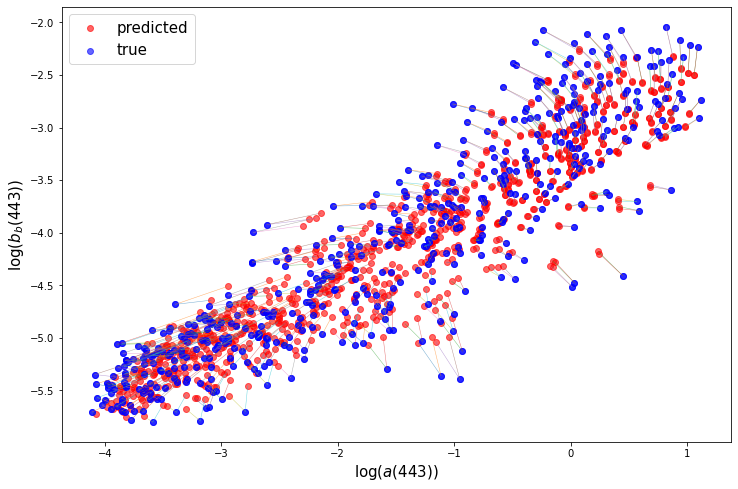

In [111]:
out_a = []
out_b = []
Out_a = []
Out_b = []
for i, o in zip(inputs, outputs):
    output = winner_net.activate(i)
    out_a.append(output[0])
    out_b.append(output[1])
    Out_a.append(o[0])
    Out_b.append(o[1])

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot()
ax1.scatter(out_a, out_b, c='r', alpha=0.6, label='predicted')
ax1.scatter(Out_a, Out_b, c='b', alpha=0.6, label='true')
for i in range(len(inputs)):
    plt.plot([out_a[i], Out_a[i]], [out_b[i], Out_b[i]], lw=0.5, alpha=0.6)
ax1.set_xlabel(r'$\log(a(443))$', fontsize=15)
ax1.set_ylabel(r'$\log(b_b(443))$', fontsize=15)
plt.legend(fontsize=15)
plt.show()


No handles with labels found to put in legend.


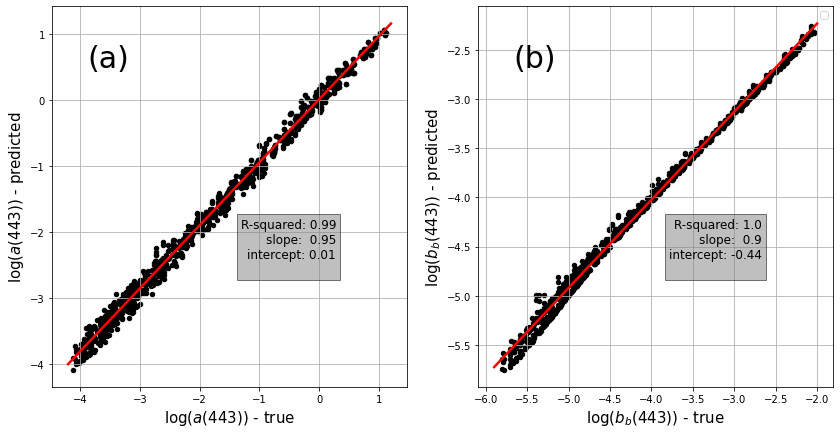

In [112]:
out_a = []
out_b = []
Out_a = []
Out_b = []
for i, o in zip(inputs, outputs):
    output = winner_net.activate(i)

    out_a.append(output[0])
    out_b.append(output[1])
    Out_a.append(o[0])
    Out_b.append(o[1])

fig, axs = plt.subplots(1, 2, figsize=(14, 7), sharey=False)
axs[0].scatter(Out_a, out_a, s=20, c='black')
axs[1].scatter(Out_b, out_b, s=20, c='black')
axs[0].set_xlabel(r'$\log(a(443))$ - true', fontsize=15)
axs[0].set_ylabel(r'$\log(a(443))$ - predicted', fontsize=15)
axs[1].set_xlabel(r'$\log(b_{b}(443))$ - true', fontsize=15)
axs[1].set_ylabel(r'$\log(b_{b}(443))$ - predicted', fontsize=15)

fit0 = LinearRegression().fit(np.asarray(Out_a).reshape(-1, 1), np.asarray(out_a).reshape(-1, 1))
y = fit0.predict(np.linspace(-4.2,1.2,100).reshape(-1, 1))
axs[0].plot(np.linspace(-4.2,1.2,100), y, c='r', lw=2.5)
Rsq = fit0.score(np.asarray(Out_a).reshape(-1, 1), np.asarray(Out_a).reshape(-1, 1))
slope = fit0.coef_[0][0]
intercept = fit0.intercept_
stats = (f'R-squared: {round(Rsq,2)}\n'
         f'slope:  {round(slope,2)}\n'
         f'intercept: {round(intercept[0],2)}\n')
bbox = dict(fc='gray', ec='black', alpha=0.5)
axs[0].text(0.8, 0.3, stats, fontsize=12, bbox=bbox,
        transform=axs[0].transAxes, horizontalalignment='right')

fit1 = LinearRegression().fit(np.asarray(Out_b).reshape(-1, 1), np.asarray(out_b).reshape(-1, 1))
y = fit1.predict(np.linspace(-5.9,-2,100).reshape(-1, 1))
axs[1].plot(np.linspace(-5.9,-2,100), y, c='r', lw=2.5)
Rsq = fit1.score(np.asarray(Out_b).reshape(-1, 1), np.asarray(out_b).reshape(-1, 1))
slope = fit1.coef_[0][0]
intercept = fit1.intercept_
stats = (f'R-squared: {round(Rsq,2)}\n'
         f'slope:  {round(slope,2)}\n'
         f'intercept: {round(intercept[0],2)}\n')
bbox = dict(fc='gray', ec='black', alpha=0.5)
axs[1].text(0.8, 0.3, stats, fontsize=12, bbox=bbox,
        transform=axs[1].transAxes, horizontalalignment='right')

for i in range(2):
    axs[i].grid(True)

for ax,label in zip(axs, ['(a)','(b)']):
        ax.text(0.1, 0.9, label, fontsize=30, transform=ax.transAxes, va='top')
plt.legend()
plt.show()


In [113]:
# VALIDATION ON IN-SITU DATA
RMSE = [0,0]
winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
# for i, o in zip(inputs, outputs):
for i, o in zip(Inputs, Outputs):
    output = winner_net.activate(i)
    for j in range(len(Outputs[0])):
        RMSE[j] += (o[j] - output[j]) ** 2
for j in range(len(Outputs[0])):
    RMSE[j] /= len(Inputs)
    RMSE[j] = sqrt(RMSE[j])

print(RMSE)
print('average RMSE:', sum(RMSE)/2)

[0.30923293366183713, 0.21394202150105823]
average RMSE: 0.2615874775814477


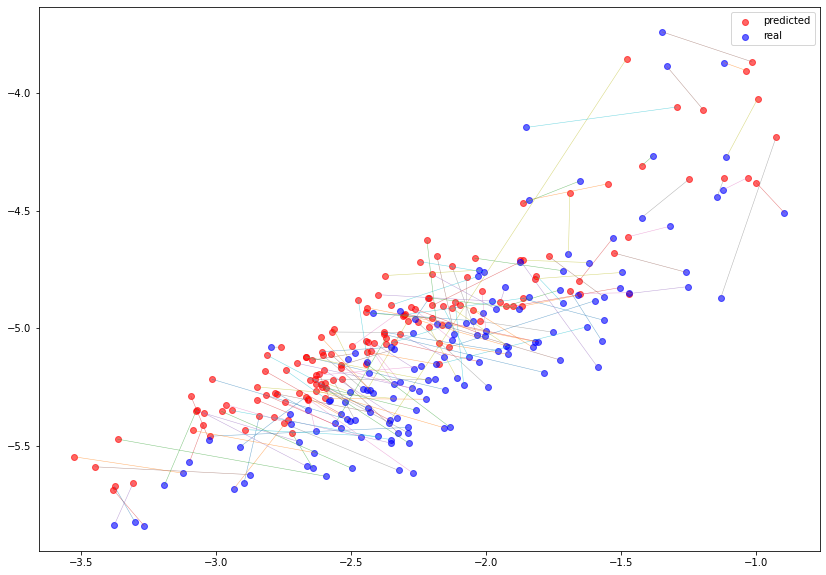

In [114]:
out_a = []
out_b = []
Out_a = []
Out_b = []
for i, o in zip(Inputs, Outputs):
    output = winner_net.activate(i)
    out_a.append(output[0])
    out_b.append(output[1])
    Out_a.append(o[0])
    Out_b.append(o[1])

fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot()
ax1.scatter(out_a, out_b, c='r', alpha=0.6, label='predicted')
ax1.scatter(Out_a, Out_b, c='b', alpha=0.6, label='real')
for i in range(len(Inputs)):
    plt.plot([out_a[i], Out_a[i]], [out_b[i], Out_b[i]], lw=0.5, alpha=0.6)
plt.legend()
plt.show()

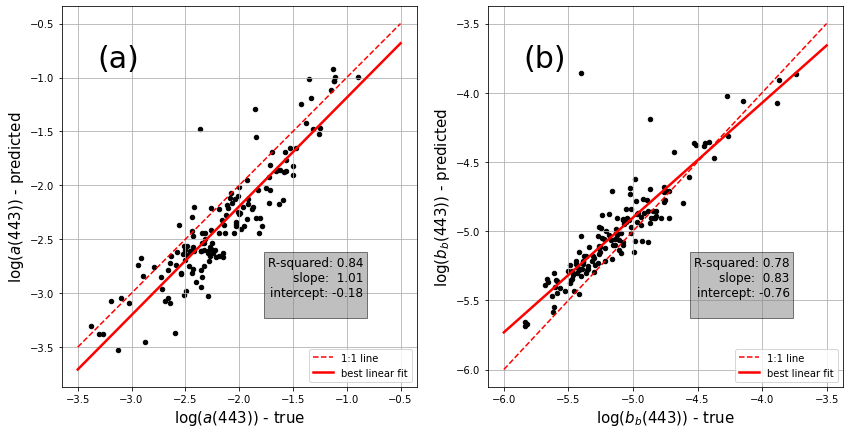

In [119]:
out_a = []
out_b = []
Out_a = []
Out_b = []
for i, o in zip(Inputs, Outputs):
    output = winner_net.activate(i)

    out_a.append(output[0])
    out_b.append(output[1])
    Out_a.append(o[0])
    Out_b.append(o[1])

fig, axs = plt.subplots(1, 2, figsize=(14, 7), sharey=False)
axs[0].scatter(Out_a, out_a, s=20, c='black')
axs[1].scatter(Out_b, out_b, s=20, c='black')
axs[0].set_xlabel(r'$\log(a(443))$ - true', fontsize=15)
axs[0].set_ylabel(r'$\log(a(443))$ - predicted', fontsize=15)
axs[1].set_xlabel(r'$\log(b_{b}(443))$ - true', fontsize=15)
axs[1].set_ylabel(r'$\log(b_{b}(443))$ - predicted', fontsize=15)

axs[0].plot(np.linspace(-3.5,-0.5,100), np.linspace(-3.5,-0.5,100), '--', c='r', lw=1.5, label='1:1 line')
axs[1].plot(np.linspace(-6,-3.5,100), np.linspace(-6,-3.5,100), '--', c='r', lw=1.5, label='1:1 line')

fit0 = LinearRegression().fit(np.asarray(Out_a).reshape(-1, 1), np.asarray(out_a).reshape(-1, 1))
y = fit0.predict(np.linspace(-3.5,-0.5,100).reshape(-1, 1))
axs[0].plot(np.linspace(-3.5,-0.5,100), y, c='r', lw=2.5, label='best linear fit')
Rsq = fit0.score(np.asarray(Out_a).reshape(-1, 1), np.asarray(Out_a).reshape(-1, 1))
slope = fit0.coef_[0][0]
intercept = fit0.intercept_
stats = (f'R-squared: {round(Rsq,2)}\n'
         f'slope:  {round(slope,2)}\n'
         f'intercept: {round(intercept[0],2)}\n')
bbox = dict(fc='gray', ec='black', alpha=0.5)
axs[0].text(0.85, 0.2, stats, fontsize=12, bbox=bbox,
        transform=axs[0].transAxes, horizontalalignment='right')

fit1 = LinearRegression().fit(np.asarray(Out_b).reshape(-1, 1), np.asarray(out_b).reshape(-1, 1))
y = fit1.predict(np.linspace(-6,-3.5,100).reshape(-1, 1))
axs[1].plot(np.linspace(-6,-3.5,100), y, c='r', lw=2.5, label='best linear fit')
Rsq = fit1.score(np.asarray(Out_b).reshape(-1, 1), np.asarray(out_b).reshape(-1, 1))
slope = fit1.coef_[0][0]
intercept = fit1.intercept_
stats = (f'R-squared: {round(Rsq,2)}\n'
         f'slope:  {round(slope,2)}\n'
         f'intercept: {round(intercept[0],2)}\n')
bbox = dict(fc='gray', ec='black', alpha=0.5)
axs[1].text(0.85, 0.2, stats, fontsize=12, bbox=bbox,
        transform=axs[1].transAxes, horizontalalignment='right')

for i in range(2):
      axs[i].grid(True)
      axs[i].legend(loc='lower right')
for ax,label in zip(axs, ['(a)','(b)']):
        ax.text(0.1, 0.9, label, fontsize=30, transform=ax.transAxes, va='top')

plt.show()
